In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import  PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
df = pd.read_csv("dublinbikes_20200101_20200401.csv",parse_dates=True)

In [40]:
cityCentre=df[df['STATION ID'].isin([33])]
print("shape of cityCentre:",cityCentre.shape)
cityCentre=cityCentre.to_numpy()

shape of cityCentre: (20369, 11)


In [41]:
cityCentre=cityCentre[1802:15626,:]
city_Month=[];city_Day=[];city_Hour=[];city_Min=[];c=0
for i in range(0,len(cityCentre)):
    cityCentre[i][2]=datetime.datetime.strptime(cityCentre[i][2], "%Y-%m-%d %H:%M:%S")
    city_Month.append(cityCentre[i][2].month)
    city_Day.append(cityCentre[i][2].day)
    city_Hour.append(cityCentre[i][2].hour)
    city_Min.append(cityCentre[i][2].minute)
city_Month=np.array(city_Month).reshape(-1,1);city_Day=np.array(city_Day).reshape(-1,1)
city_Hour=np.array(city_Hour).reshape(-1,1);city_Min=np.array(city_Min).reshape(-1,1)
record_data=np.concatenate((city_Month,city_Day,city_Hour,city_Min),axis=1)
cityCentreAvaliable=cityCentre[:,6].reshape(-1,1)


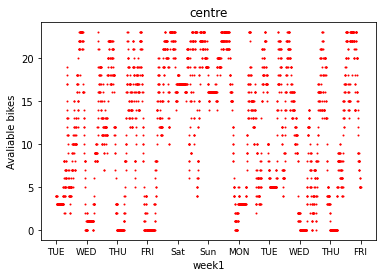

In [42]:
x_ticks = np.linspace(0, 2880, 11)
x_labels = ['TUE','WED', 'THU', 'FRI', 'Sat', 'Sun', 'MON','TUE','WED', 'THU', 'FRI']
X=np.linspace(1,2880,num=2880).reshape(-1,1)
plt.scatter(X,cityCentreAvaliable[2016:4896],color='red',s=1)
plt.title('centre')
plt.xlabel('week1')
plt.ylabel('Avaliable bikes')
plt.xticks(x_ticks, x_labels, fontsize=9)

plt.show()

In [43]:
scale=MinMaxScaler()
scale.fit(cityCentreAvaliable)
cityCentreAvaliableScale=scale.transform(cityCentreAvaliable)

In [44]:
week=[]
j=1
num=1
for i in range(len(cityCentre)):
    if(cityCentre[i][1]==num):
        week.append(j)
    elif(cityCentre[i][1]!=num):
        num=cityCentre[i][1]
        j+=1
        if(j>7):
            j=1
        week.append(j)
week=np.array(week).reshape(-1,1)
week.shape

(13824, 1)

In [45]:
for i in range(len(week)):
    if(week[i]==7 or week[i]==6):
        week[i]=0
    else:
        week[i]=1


In [46]:
cityCentre=np.concatenate((week,cityCentreAvaliable),axis=1)
cityCentre.shape

(13824, 2)

In [47]:
start=4032
def series_to_supervised_time(data, time_size,start,skip):
    size=len(data)-start
    para_size=data.shape[1]
    sampletimes=np.empty([size,time_size*para_size])
    target=np.empty([size,time_size*para_size])
    target=cityCentreAvaliable[start:,:]
    for i in range(size):
        for j in range(time_size):
            sampletimes[i,j*para_size:(j+1)*para_size]=cityCentre[start+i-2-j*skip,:]#10mins
            #sampletimes[i,j*para_size:(j+1)*para_size]=cityCentre[start+i-6-j*skip,:]#30mins
            #sampletimes[i,j*para_size:(j+1)*para_size]=cityCentre[start+i-12-j*skip,:]#1h
    return sampletimes,target  

def series_to_supervised_day(data, time_size, start):
    size=len(data)-start
    para_size=data.shape[1]
    sampledays=np.empty([size,time_size*para_size])
    for i in range(size):
        for j in range(time_size):
            sampledays[i,j*para_size:(j+1)*para_size]=cityCentre[start+i-288*(j+1),:]
    return sampledays
def series_to_supervised_week(data, time_size, start):
    size=len(data)-start
    para_size=data.shape[1]
    sampleweeks=np.empty([size,time_size*para_size])
    for i in range(size):
        for j in range(time_size):
            sampleweeks[i,j*para_size:(j+1)*para_size]=cityCentre[start+i-288*7*(j+1),:]
    return sampleweeks

sampletimes,target=series_to_supervised_time(cityCentre, 3, start,3)
# for i in range(len(target)-1):
#     for j in range(time_size):
#         sampletimes[i][j*2+1]=sampletimes[i][j*2+1]-sampletimes[i+1][j*2+1]
sampledays=series_to_supervised_day(cityCentre,2,start)
sampleweeks=series_to_supervised_week(cityCentre,1,start)
sample=np.concatenate((sampletimes,sampledays,sampleweeks),axis=1)
print(target.shape)
print(sampletimes.shape)
print(sampledays.shape)
print(sampleweeks.shape)
#cityCentre_train_data,cityCentre_test_data,cityCentre_train,cityCentre_test=train_test_split(sample,target,test_size=0.2,random_state=0)

(9792, 1)
(9792, 6)
(9792, 4)
(9792, 2)


centre_Baseline_MSE(1h):3.2503
centre_Baseline_MAE(1h):1.0013


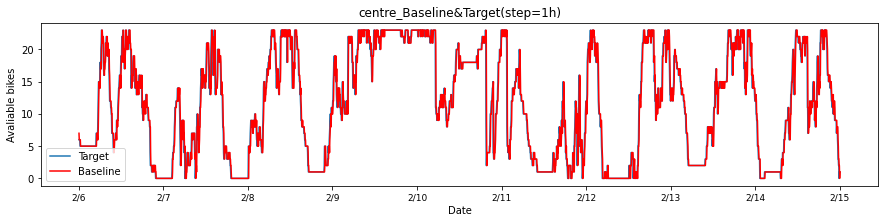

In [48]:
baseline=mean_squared_error(sampletimes[:,1],target)
baseline0=mean_absolute_error(sampletimes[:,1],target)
print("centre_Baseline_MSE(1h):%.4f"%baseline)
print("centre_Baseline_MAE(1h):%.4f"%baseline0)
x_ticks = np.linspace(0, 2880, 10)
x_labels = ['2/6','2/7', '2/8', '2/9', '2/10', '2/11', '2/12','2/13','2/14', '2/15']
X=np.linspace(1,2880,num=2880).reshape(-1,1)
plt.figure(figsize=(15, 3))
plt.title('centre_Baseline&Target(step=1h)')
plt.plot(X,target[:2880])
plt.plot(X,sampletimes[:2880,1],color='red')
plt.xlabel('Date')
plt.ylabel('Avaliable bikes')
plt.xticks(x_ticks, x_labels, fontsize=9)
plt.legend(['Target','Baseline'])
plt.show()


In [49]:
sampleTest=sample[7000:,:];targetTest=target[7000:,:]
sample=sample[:7000];target=target[:7000]

mean_error: [6.123832154676072, 4.815404766771797, 4.379315913097772, 4.161287167877211, 4.030471689027026, 3.943262577491669, 3.880970485932088]
absolute_error: [1.8066313648972294, 1.4846453516666325, 1.37737584160125, 1.32375525593403, 1.2915846832058588, 1.2701388356448442, 1.2548205025924912]
score: 0.9491543673847604


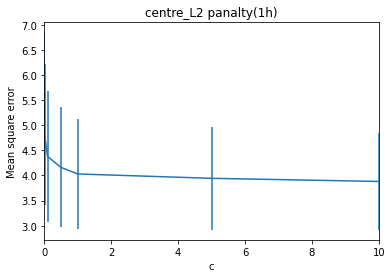

In [50]:
mean_error=[];std_error=[];absolute_error=[]
temp=[]
absolute=[]
tscv = TimeSeriesSplit(n_splits=3)
c_range=[0.00001,0.01,0.1,0.5,1,5,10]
for c in c_range:
    model = Ridge(alpha=1/(2*c))
    for train, test in tscv.split(sample):
        model.fit(sample[train],target[train])
        
        pred=model.predict(sample[test])
        temp.append(mean_squared_error(target[test],pred))
        absolute.append(mean_absolute_error(target[test],pred))
    mean_error.append(np.array(temp).mean())
    absolute_error.append(np.array(absolute).mean())
    std_error.append(np.array(temp).std())
print('mean_error:',mean_error)
print('absolute_error:',absolute_error)
score = model.score(sample,target)
print('score:',score)
plt.errorbar(c_range,mean_error,yerr=std_error)
plt.title('centre_L2 panalty(1h)')
plt.xlabel('c'); plt.ylabel('Mean square error')
plt.xlim((0,10))
plt.show()

centre_Prediction_MSE(10mins):2.5179
centre_Prediction_MAE(10mins):0.9928
centre_Prediction_score(10mins):0.9580


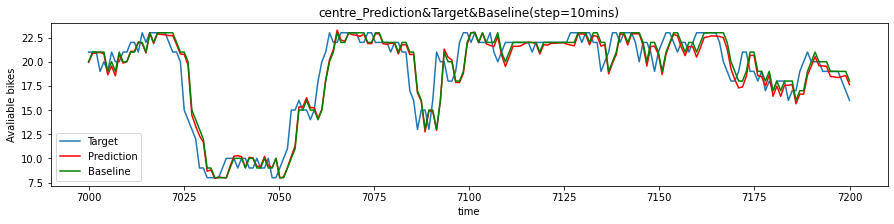

In [51]:
model = Ridge(alpha=1/(2*10))
sampletimes,target=series_to_supervised_time(cityCentre, 10, start,3)
sampledays=series_to_supervised_day(cityCentre,0,start)
sampleweeks=series_to_supervised_day(cityCentre,1,start)
sample=np.concatenate((sampletimes,sampledays,sampleweeks),axis=1)
sampleTest=sample[7000:,:];targetTest=target[7000:,:]
sample=sample[:7000];target=target[:7000]

model.fit(sample,target)
pred=model.predict(sampleTest)
X=np.linspace(7000,7200,num=200).reshape(-1,1)
plt.figure(figsize=(15, 3))
#print(Min_TEMP_pred.shape)
plt.title('centre_Prediction&Target&Baseline(step=10mins)')
plt.plot(X,targetTest[:200])
plt.plot(X,pred[:200],color='red')
plt.plot(X,sampletimes[7000:7200,1],color='green')
plt.xlabel('time')
plt.ylabel('Avaliable bikes')
plt.legend(['Target','Prediction','Baseline'])
print("centre_Prediction_MSE(10mins):%.4f"%mean_squared_error(pred,targetTest))
print("centre_Prediction_MAE(10mins):%.4f"%mean_absolute_error(pred,targetTest))
print("centre_Prediction_score(10mins):%.4f"%model.score(sampleTest,targetTest))

mean_error: [57.11784361530562, 30.16309088352578, 21.17289081874492, 16.67713074269822, 13.98055138061395, 12.183301275528729]
absolute_error: [6.508736476802722, 3.7975162142793875, 2.8962217394355725, 2.445699176671049, 2.175937697528805, 1.9966010049527914]
score: 0.951359140074942


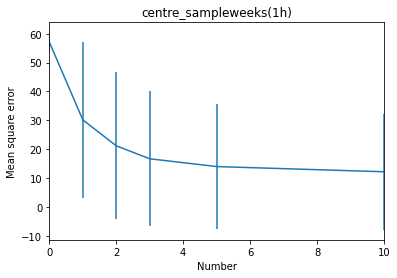

In [55]:
mean_error=[];std_error=[];absolute_error=[]
temp=[]
absolute=[]
tscv = TimeSeriesSplit(n_splits=3)
c_range=[0,1,2,3,5,10]
for c in c_range:
    model = Ridge(alpha=1/(2*10))
    sampletimes,target=series_to_supervised_time(cityCentre, c, start,3)
    sampledays=series_to_supervised_day(cityCentre,1,start)
    sampleweeks=series_to_supervised_day(cityCentre,0,start)
    sample=np.concatenate((sampletimes,sampledays,sampleweeks),axis=1)
    for train, test in tscv.split(sample):
        model.fit(sample[train],target[train])
        
        pred=model.predict(sample[test])
        temp.append(mean_squared_error(target[test],pred))
        absolute.append(mean_absolute_error(target[test],pred))
    mean_error.append(np.array(temp).mean())
    absolute_error.append(np.array(absolute).mean())
    std_error.append(np.array(temp).std())
print('mean_error:',mean_error)
print('absolute_error:',absolute_error)
score = model.score(sample,target)
print('score:',score)
plt.errorbar(c_range,mean_error,yerr=std_error)
plt.title('centre_sampleweeks(1h)')
plt.xlabel('Number'); plt.ylabel('Mean square error')
plt.xlim((0,10))
plt.show()

3.1737761024876594

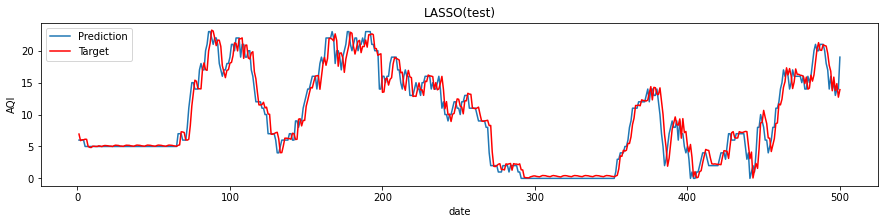

In [56]:
pred=model.predict(sample)
X=np.linspace(1,500,num=500).reshape(-1,1)
plt.figure(figsize=(15, 3))
#print(Min_TEMP_pred.shape)
plt.title('LASSO(test)')
plt.plot(X,target[:500])
plt.plot(X,pred[0:500],color='red')
plt.xlabel('date')
plt.ylabel('AQI')
plt.legend(['Prediction','Target'])
mean_squared_error(pred,target)

In [57]:
print("intercept:%.4f" % model.intercept_)
for i in range(len(model.coef_[0])):
    print("coef:%.4f"% model.coef_[0][i])

intercept:0.2962
coef:0.0054
coef:1.0322
coef:-0.0338
coef:-0.0462
coef:0.0036
coef:-0.0270
coef:0.0519
coef:0.0112
coef:-0.0528
coef:-0.0027
coef:0.0430
coef:-0.0065
coef:-0.0173
coef:-0.0001
coef:0.0054
coef:0.0170
coef:-0.0338
coef:0.0031
coef:0.0036
coef:-0.0202
coef:0.0036
coef:0.0171
